## Лабораторная работа №5. Применение сверточных нейронных сетей (бинарная классификация)

#### Данные:
Набор данных DogsVsCats, который состоит из изображений различной размерности, содержащих фотографии собак и кошек. 
Обучающая выборка включает в себя 25 тыс. изображений (12,5 тыс. кошек: cat.0.jpg, …, cat.12499.jpg и 12,5 тыс. собак: dog.0.jpg, …, dog.12499.jpg), а контрольная выборка содержит 12,5 тыс. неразмеченных изображений. 
Скачать данные, а также проверить качество классификатора на тестовой выборке можно на сайте Kaggle -> https://www.kaggle.com/c/dogs-vs-cats/data

#### Ход выполнения:


###### Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.
  
Зарегистрируемся на сайте kaggle и скачаем kaggle.json файл с API token для использования команд kaggle.  

In [1]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


Распакуем данные.

In [2]:
import io
import os
import zipfile


def extract(filename):
    z = zipfile.ZipFile(filename)
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    for f in z.namelist():
        if os.path.exists(f):
            print('%s already present - Skipping extraction of %s.' % (root, f))
        else:
            if f.endswith('.zip'):
                dirname = os.path.splitext(f)[0]  
                if os.path.exists(dirname):
                    print('%s already present - Skipping extraction of %s.' % (root, f))
                else:
                    os.mkdir(dirname)  
                    content = io.BytesIO(z.read(f))
                    zip_file = zipfile.ZipFile(content)
                    for i in zip_file.namelist():
                        zip_file.extract(i, dirname)
            else:
                z.extract(f, ".")

extract("dogs-vs-cats.zip")

dogs-vs-cats already present - Skipping extraction of sampleSubmission.csv.
dogs-vs-cats already present - Skipping extraction of test1.zip.
dogs-vs-cats already present - Skipping extraction of train.zip.


Проверим, что классы являются сбалансированными.

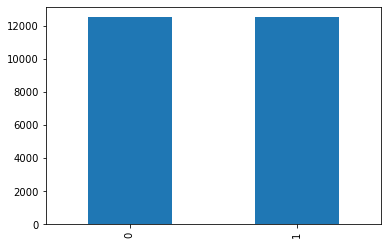

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

filenames = os.listdir("./train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("1")
    else:
        categories.append("0")

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

df['category'].value_counts().plot.bar()
plt.show()

Отобразим случайную картинку из набора данных.

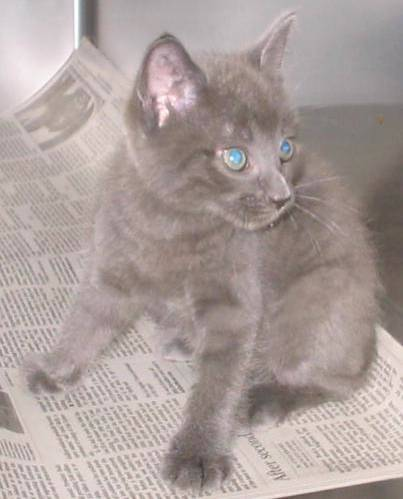

In [4]:
import random
from IPython.display import display, Image

train_dir = "./train/train/"

sample = random.choice(filenames)
image_file = os.path.join(train_dir, sample)
image_to_display = Image(filename=image_file)
display(image_to_display)

###### Задание 2.
Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?


Используем модель с несколькими сверточными слоями с чередованием пулинга с максимальной функцией, нормализацией и метод сброса нейронов (dropout), а также с полносвязанными слоями для вывода результата сети. 

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

Разделим исходный набор данных на обучающую и валидационную выборку.

In [6]:
from sklearn.model_selection import train_test_split

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

Преобразуем данные, чтобы были более адаптированы к модели, которую собираемся тренировать. 

In [7]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [9]:
epochs = 2

def train_model(model):
    history = model.fit_generator(
        train_generator, 
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=total_validate//batch_size,
        steps_per_epoch=total_train//batch_size,
        callbacks=callbacks
    )
    return history


history = train_model(model)

Epoch 1/2
1333/1333 [==============================] - 1175s 881ms/step - loss: 0.6648 - accuracy: 0.6748 - val_loss: 0.6327 - val_accuracy: 0.6316
Epoch 2/2
1333/1333 [==============================] - 1031s 773ms/step - loss: 0.4595 - accuracy: 0.7870 - val_loss: 0.4739 - val_accuracy: 0.7834


Отобразим графики точности обучения и потерь.

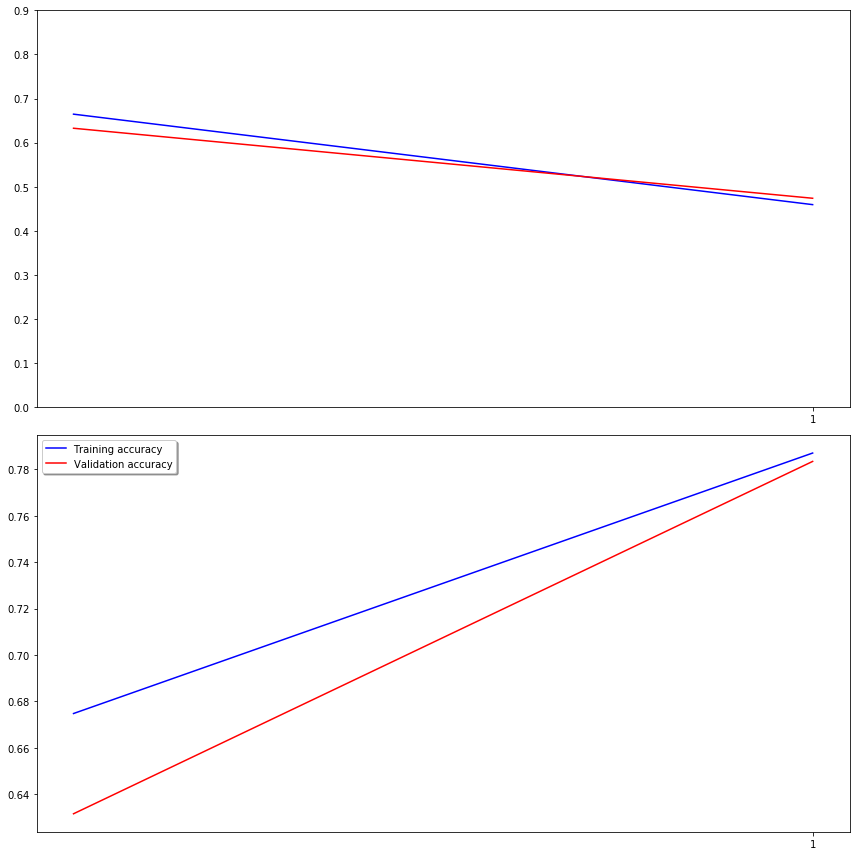

In [10]:
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

После обучения модель дает результат точности в 78.7%.

Проверим на тестовой выборке результат распознования.

In [11]:
test_filenames = os.listdir("./test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


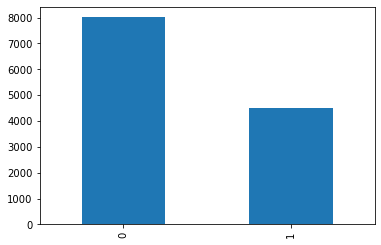

In [12]:
def predict_model(model):
    predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
    test_df['category'] = np.argmax(predict, axis=-1)
    label_map = dict((v,k) for k,v in train_generator.class_indices.items())
    test_df['category'] = test_df['category'].replace(label_map)
    test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
    test_df['category'].value_counts().plot.bar()


predict_model(model)    

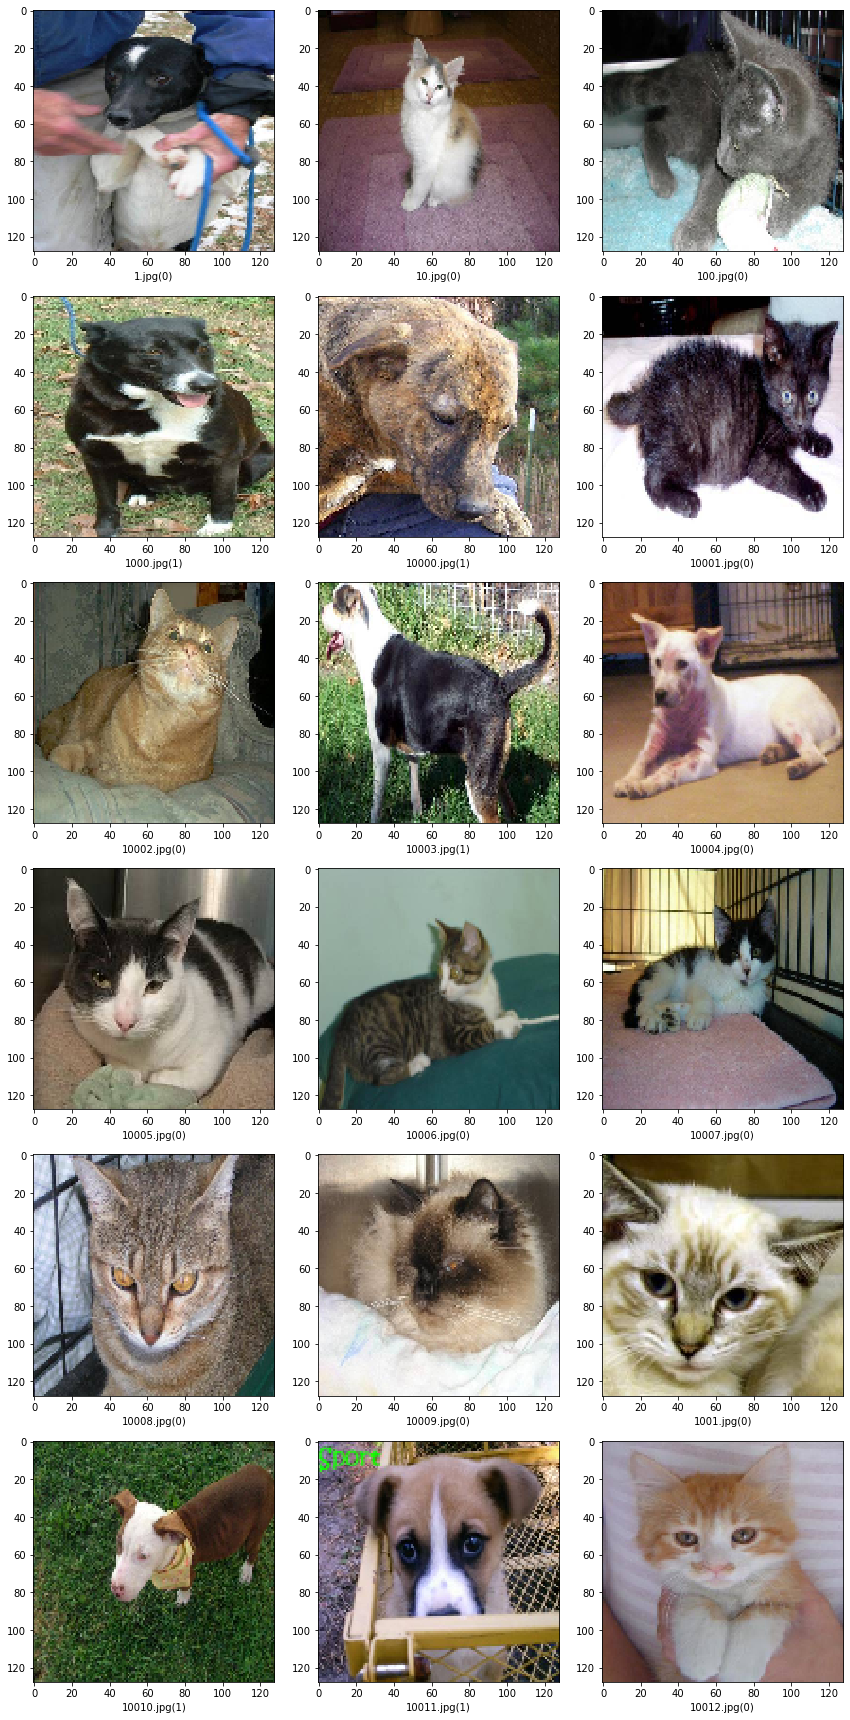

In [13]:
def show_samples():
    sample_test = test_df.head(18)
    sample_test.head()
    plt.figure(figsize=(12, 24))
    for index, row in sample_test.iterrows():
        filename = row['filename']
        category = row['category']
        img = load_img("./test1/test1/"+filename, target_size=IMAGE_SIZE)
        plt.subplot(6, 3, index+1)
        plt.imshow(img)
        plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    plt.tight_layout()
    plt.show()

    
show_samples()    

Модель может предсказывать данные, но не всегда имеет точные показатели.

###### Задание 3.
Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 

Добавим data augmentation для набора данных и отобразим пример.

Found 20000 validated image filenames belonging to 2 classes.
Found 1 validated image filenames belonging to 1 classes.


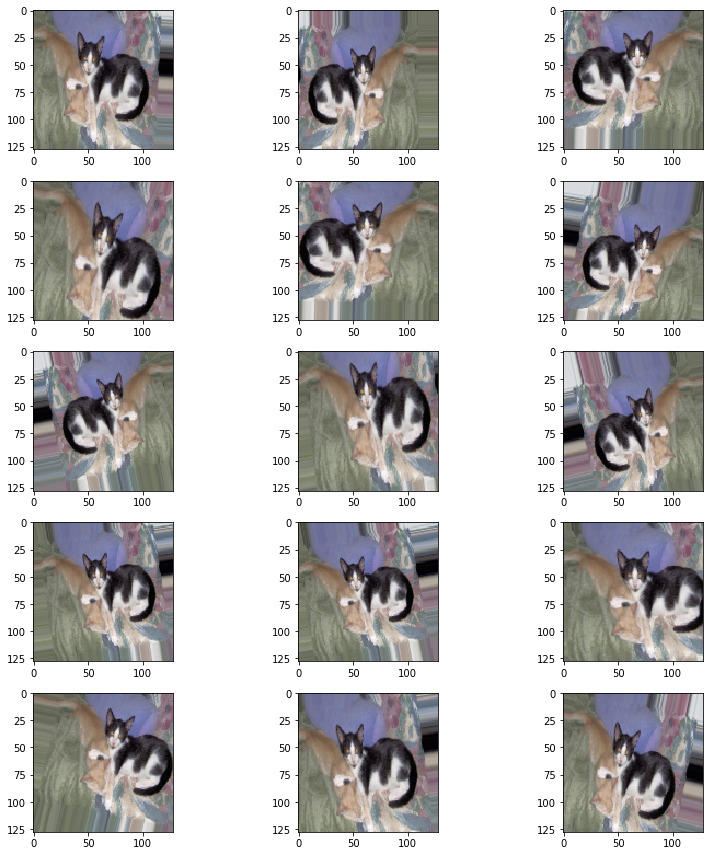

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [15]:
history = train_model(model)

Epoch 1/2
1333/1333 [==============================] - 990s 743ms/step - loss: 0.4587 - accuracy: 0.7858 - val_loss: 0.4636 - val_accuracy: 0.8006
Epoch 2/2
1333/1333 [==============================] - 1027s 770ms/step - loss: 0.4385 - accuracy: 0.8012 - val_loss: 0.3941 - val_accuracy: 0.8322


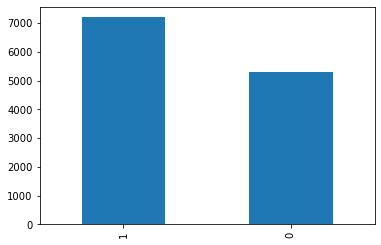

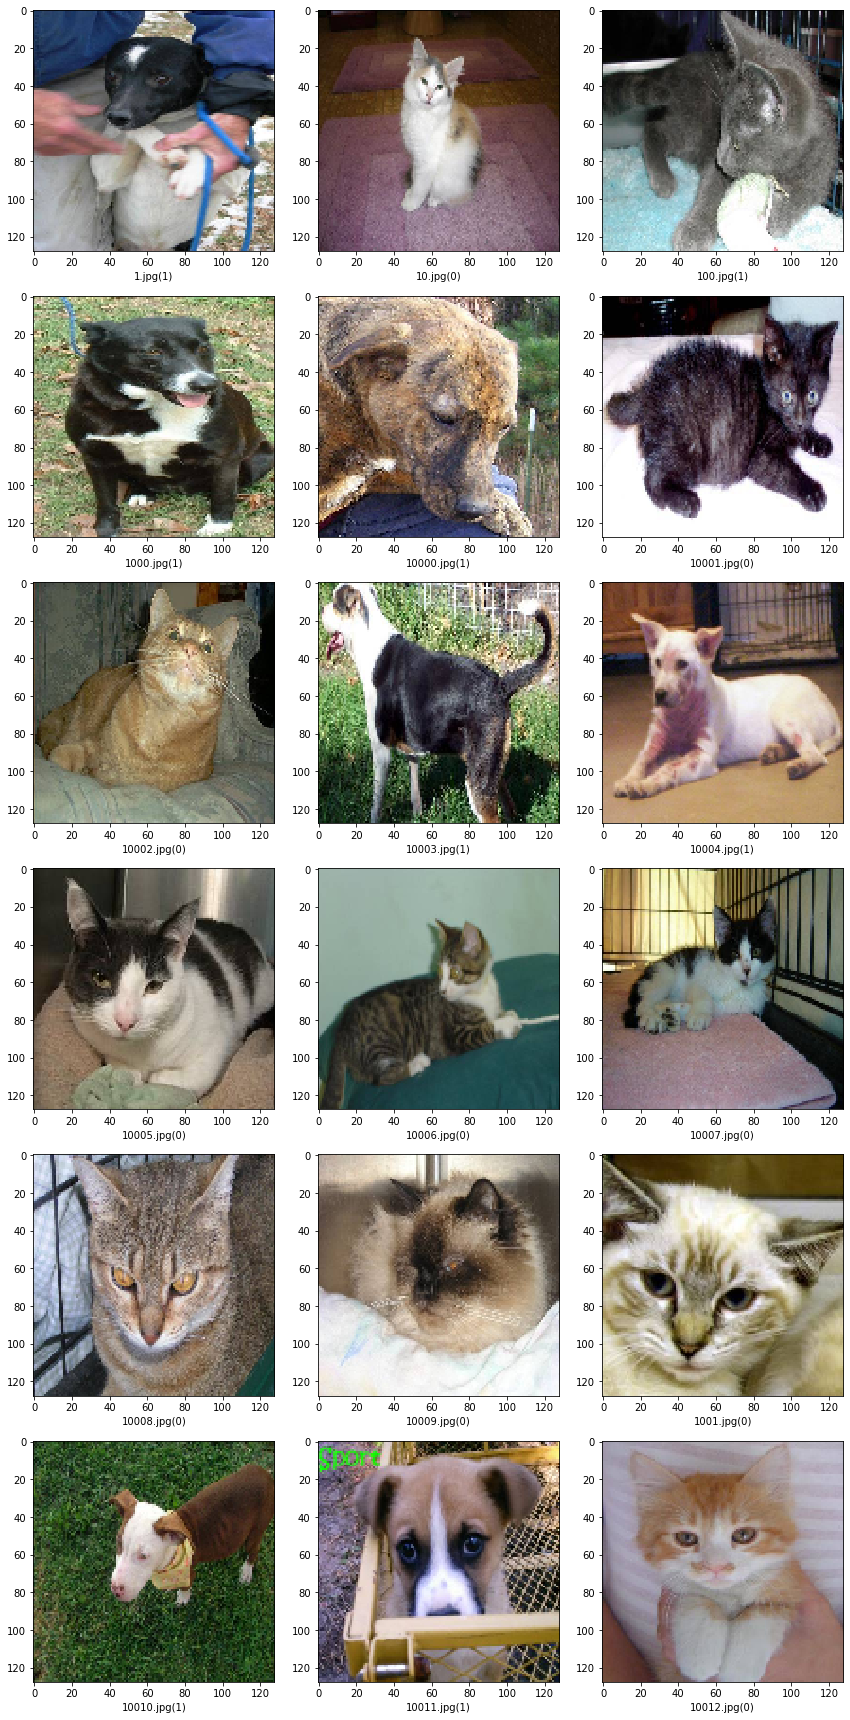

In [16]:
predict_model(model)
show_samples() 

После обучения с data augmentation модель дает результат точности в 80.1%. Сеть смогла успешно предсказать маркеры рисунков при проверке на тестовой выборке.

###### Задание 4.
Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение.  
Как это повлияло на качество классификатора?  
Какой максимальный результат удалось получить на сайте Kaggle? Почему?


Используем готовую нейронную сеть VGG16, применив передаточное обучение.

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Dense, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [18]:
from tensorflow.keras.optimizers import SGD

model.compile(loss='binary_crossentropy', optimizer=SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train/train/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [20]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/2
1333/1333 [==============================] - 6348s 5s/step - loss: 0.3703 - accuracy: 0.8259 - val_loss: 0.2076 - val_accuracy: 0.9131
Epoch 2/2
1333/1333 [==============================] - 6485s 5s/step - loss: 0.2372 - accuracy: 0.9010 - val_loss: 0.1894 - val_accuracy: 0.9179


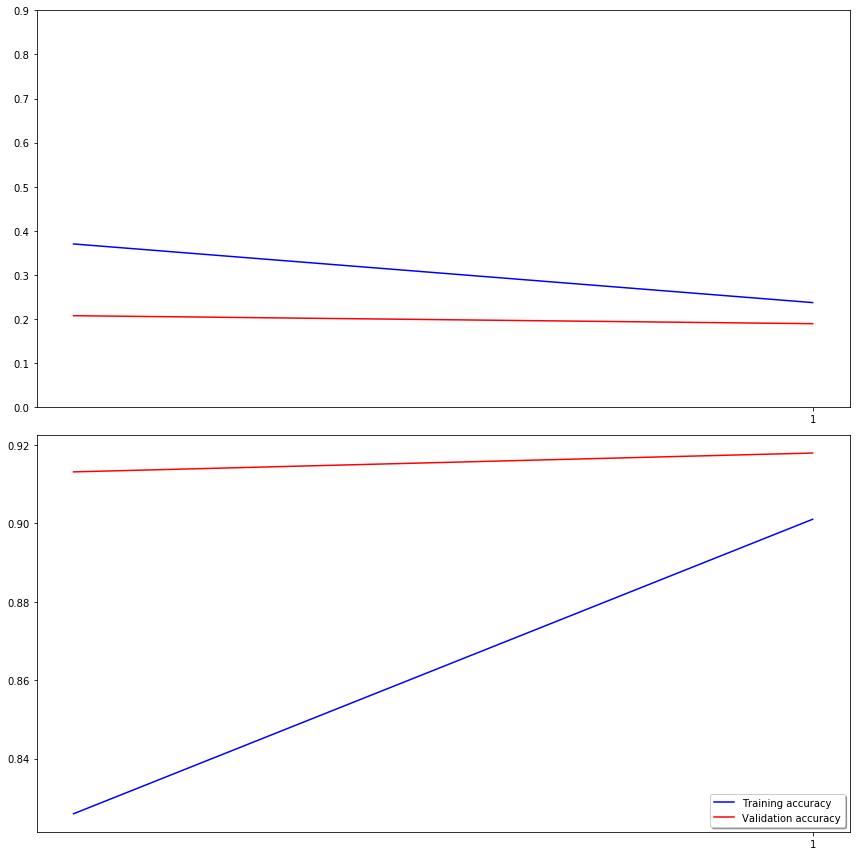

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Качество классификатора выросло до 90.1%.

Таким образом, максимальный результат на сайте Kaggle 98.9%. В данном примере использовалась VGG16 с передатчоным обучением. При увеличении количества эпох результат получается точнее и доходит до 96.7%.